In [1]:
import vof
from vof import forecaster
from vof import optimizer

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import pandas as pd
import statsmodels.api as sm
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
import statsmodels.tsa.stattools
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import time
import random
#from fbprophet import Prophet
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from datetime import date
import nevergrad as ng
from joblib import Parallel, delayed
import time

from darts.utils import timeseries_generation as tg
from darts import TimeSeries
from darts.metrics import rmse
# from darts import SeasonalityMode, TrendMode, ModelMode

from darts.models import Theta, FFT, ExponentialSmoothing, Prophet, RegressionModel,NaiveSeasonal,LightGBMModel,RandomForest,forecasting
# import darts.models
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode


plt.rcParams['figure.figsize'] = [18, 8]
plt.rcParams.update({'font.size': 22})

In [3]:
'''data = pd.read_csv('data/ecomm/sales_train_data_merged.csv',index_col=0).fillna(0)
data

top_items = data.groupby('item_id').sum().sort_values(by='sales').index[-100:]
data.loc[data.item_id.isin(top_items)].to_csv('data/ecomm/sales_train_data_merged_top100_items.csv')'''

"data = pd.read_csv('data/ecomm/sales_train_data_merged.csv',index_col=0).fillna(0)\ndata\n\ntop_items = data.groupby('item_id').sum().sort_values(by='sales').index[-100:]\ndata.loc[data.item_id.isin(top_items)].to_csv('data/ecomm/sales_train_data_merged_top100_items.csv')"

In [4]:
data = pd.read_csv('data/ecomm/sales_train_data_merged_top100_items.csv',index_col=0).fillna(0)
data.index = data.index.astype('datetime64[ns]')

#data['sin_wday'] = np.sin(2*np.pi*data.wday/7)
#data['cos_wday'] = np.cos(2*np.pi*data.wday/7)

#data.set_index('date', inplace=True)
data_subset = data.loc['2011-10-01':'2012-10-01']

In [5]:
data_subset

item_id  sell_price  wday  snap_CA  snap_TX  snap_WI  \
date                                                                       
2012-03-03      FOODS_1_004       1.780   1.0      1.0      1.0      1.0   
2012-03-04      FOODS_1_004       1.780   2.0      1.0      0.0      0.0   
2012-03-05      FOODS_1_004       1.780   3.0      1.0      1.0      1.0   
2012-03-06      FOODS_1_004       1.780   4.0      1.0      1.0      1.0   
2012-03-07      FOODS_1_004       1.780   5.0      1.0      1.0      0.0   
...                     ...         ...   ...      ...      ...      ...   
2012-09-27  HOUSEHOLD_1_521       0.961   6.0      0.0      0.0      0.0   
2012-09-28  HOUSEHOLD_1_521       0.961   7.0      0.0      0.0      0.0   
2012-09-29  HOUSEHOLD_1_521       0.961   1.0      0.0      0.0      0.0   
2012-09-30  HOUSEHOLD_1_521       0.961   2.0      0.0      0.0      0.0   
2012-10-01  HOUSEHOLD_1_521       0.961   3.0      1.0      1.0      0.0   

            sales  special_events      sin_wday  cos_wday  
date                                                       
2012-03-03    0.0             0.0  7.818315e-01  0.623490  
2012-03-04    0.0             0.0  9.749279e-01 -0.222521  
2012-03-05    0.0             0.0  4.338837e-01 -0.900969  
2012-03-06    0.0             0.0 -4.338837e-01 -0.900969  
2012-03-07    1.0             0.0 -9.749279e-01 -0.222521  
...           ...             ...           ...       ...  
2012-09-27   40.0             0.0 -7.818315e-01  0.623490  
2012-09-28   51.0             0.0 -2.449294e-16  1.000000  
2012-09-29   84.0             0.0  7.818315e-01  0.623490  
2012-09-30   60.0             0.0  9.749279e-01 -0.222521  
2012-10-01   76.0             0.0  4.338837e-01 -0.900969  

[30760 rows x 10 columns]

In [6]:
top_items = data_subset.groupby('item_id').sum().sort_values(by='sales').index[-1:]

alt.data_transformers.disable_max_rows()

alt.Chart(data_subset.loc[data_subset.item_id.isin(top_items)].reset_index()).mark_line().encode(
    x='date:T',
    y=alt.Y('sales:Q'),
    color='item_id',
    tooltip=['item_id','date:T','sales:Q']
).properties(width=500, height=400)

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


alt.Chart(...)

In [7]:
def get_input_item(item_id='FOODS_3_555'):
    item = data_subset.loc[data_subset.item_id.isin([item_id])]
    item.loc[item.sales<10,'sales'] = item.sales.median()
    return item

In [8]:
def eval_model(model, 
               input_timeseries,
               past_covariates=None, 
               future_covariates=None, 
               retrain = False, 
               plot_backtest=True):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=input_timeseries, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.33, 
                                          retrain=retrain,
                                          verbose=True, 
                                          forecast_horizon=7)
    
    if plot_backtest:
        input_timeseries[-len(backtest)-14:].plot()
        backtest.plot(label='backtest (n=10)')
    print(str(model)+' Backtest RMSE = {}'.format(rmse(input_timeseries, backtest)))


def get_historical_forecasts(model, 
                             input_timeseries,
                             future_covariates,
                             model_display_name, 
                             future_covs=False):

    horizon = 7
    
    if future_covs == False:
        #print(model_display_name, 'no future_covs')
        forecast = model.historical_forecasts(input_timeseries,
                                              forecast_horizon=horizon, 
                                              stride=1, 
                                              verbose=True,
                                              start=60, 
                                              last_points_only=False, 
                                              overlap_end=False)
    else:
        #print(model_display_name, 'with future_covs')
        forecast = model.historical_forecasts(input_timeseries,
                                              forecast_horizon=horizon, 
                                              stride=1, 
                                              verbose=True,
                                              future_covariates=future_covariates,
                                              start=60,
                                              last_points_only=False,
                                              overlap_end=False)
        
    res_df = pd.DataFrame()

    for i in range(len(forecast)):
        pred_df = forecast[i].pd_dataframe()
        pred_df['prediction_date'] = forecast[i].get_timestamp_at_point(0)
        pred_df['model'] = model_display_name
        pred_df.reset_index(inplace=True)
        pred_df.columns = ['ts','value','prediction_date','model']
        res_df = res_df.append(pred_df)
    
    if future_covs == False:
        return res_df.iloc[:-(horizon*7)]
    else:
        return res_df
    #return res_df

In [9]:
def create_forecast_for_item(itemid):
    
    input_timeseries = TimeSeries.from_dataframe(get_input_item(itemid), value_cols=['sales'])

    future = TimeSeries.from_dataframe(get_input_item(itemid), 
                                       value_cols=['sin_wday','cos_wday','special_events'])
    
    print(future)
    # We first set aside the first 33% as training series:
    input_train, _ = input_timeseries.split_before(0.33)

    #naive_model_daily = NaiveSeasonal(K=1)
    #naive_model_daily.fit(input_train)

    naive_model_weekly = NaiveSeasonal(K=7)
    naive_model_weekly.fit(input_train)

    regr_model_lags =  RegressionModel(lags=list(range(-14,0)))
    regr_model_lags.fit(input_train)

    regr_model_cov = RegressionModel(lags=list(range(-14,0)),lags_future_covariates=[-14,-7,0,1,7])
    regr_model_cov.fit(input_train,future_covariates=future)

    lgbm_model_cov = LightGBMModel(lags=list(range(-14,0)),lags_future_covariates=[-14,-7,0,1,7])
    lgbm_model_cov.fit(input_train,future_covariates=future)

    lgbm_model = LightGBMModel(lags=list(range(-14,0)))
    lgbm_model.fit(input_train)
    
    theta_model =  Theta(2, seasonality_period=7, season_mode=SeasonalityMode.MULTIPLICATIVE)
    theta_model.fit(input_train)



    #eval_model(naive_model_daily, input_timeseries, retrain=True, plot_backtest=False)
    #eval_model(naive_model_weekly,input_timeseries, retrain=True, plot_backtest=False)
    #eval_model(regr_model_lags,input_timeseries, plot_backtest=False)
    #eval_model(regr_model_cov,input_timeseries, plot_backtest=False)
    #eval_model(lgbm_model_cov,input_timeseries, plot_backtest=False)
    
    models = {'Naive weekly':[naive_model_weekly,False],
              'RegressionModelLags':[regr_model_lags,False],
              'RegressionModelCov':[regr_model_cov,True],
              'LGBM_cov':[lgbm_model_cov,True],
              'LGBM_no_cov':[lgbm_model,False],
              'Theta':[theta_model,False],
              #'FFT':[fft_model,False],
              #'ExponentialSmoothing':[exp_smooth_model,False],
              #'Prophet':[prophet_model,False]
         }

    forcasts_df = pd.DataFrame()

    runtime_df = pd.DataFrame(index=models.keys(),columns=['runtime'])
    
    parallel_forecasts = (Parallel(n_jobs=-1, verbose = 1000)\
                          (delayed(get_historical_forecasts)(models[model][0],
                                                             input_timeseries=input_timeseries,
                                                             model_display_name = model,
                                                             future_covariates=future,
                                                             future_covs = models[model][1]) for model in models.keys()))
    #merge all models into a single dataframe forcasts_df
    for i in parallel_forecasts:
        forcasts_df = forcasts_df.append(i)

    forcasts_df['item_id'] = itemid

    return forcasts_df


In [10]:
optimization_df_parallel = (Parallel(n_jobs=-1, verbose = 1000)\
                            (delayed(create_forecast_for_item)(item) for item in top_items.values))

#merge all items into a single dataframe
optimization_df = pd.DataFrame()
for i in optimization_df_parallel:
    optimization_df = optimization_df.append(i)

    optimization_df

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.4min finished


In [11]:
fact = optimization_df.loc[optimization_df.model=='Naive weekly'].copy()#.join('tmp.y.loc[optimization_df.index]')
fact.set_index(['ts','item_id'], inplace=True)
fact['model'] = 'Fact'
fact['value'] = data.reset_index().set_index(['date','item_id'])['sales']

fact.reset_index(inplace=True)

if len(optimization_df.loc[optimization_df.model=='Fact'])==0:
    optimization_df = optimization_df.append(fact)

In [12]:
alt.data_transformers.disable_max_rows()

alt.Chart(optimization_df.reset_index()).mark_line().encode(
    x='ts:T',
    y=alt.Y('value:Q',scale=alt.Scale(zero=True)),
    color=alt.Color('prediction_date:N', legend=None),
    row='model:N',
    column='item_id:N'
).properties(width=200, height=150)#.interactive()

alt.Chart(...)

### Evaluation function for all item_ids

In [13]:
#optimization_df.set_index(['item_id','prediction_date','ts'])
from sklearn import metrics
import math 
def get_item_rmse(item_id):
    
    res = pd.DataFrame(index=optimization_df.model.unique(), columns=['rmse'])
    
    df = optimization_df.loc[optimization_df.item_id==item_id].set_index(['prediction_date','ts'])
        
    for m in optimization_df.model.unique():
        mse = metrics.mean_squared_error(df.loc[df.model=='Fact','value'],df.loc[df.model==m,'value'])        
        res.loc[m,'rmse'] = math.sqrt(mse)
    
    res['rmse_normalized'] = res['rmse']/res.loc['Naive weekly','rmse']
    res['item_id'] = item_id
    res = res.drop('Fact').reset_index()
    res.columns = ['model','rmse','rmse_normalized','item_id']
    return res

eval_df = pd.DataFrame()

for item in top_items.values:
    eval_df = eval_df.append(get_item_rmse(item), ignore_index=True)
    
eval_df

model        rmse rmse_normalized      item_id
0         Naive weekly  197.483355             1.0  FOODS_3_090
1  RegressionModelLags  224.584335        1.137232  FOODS_3_090
2   RegressionModelCov   317.83504        1.609427  FOODS_3_090
3             LGBM_cov  193.385215        0.979248  FOODS_3_090
4          LGBM_no_cov  201.460331        1.020138  FOODS_3_090
5                Theta  170.759775        0.864679  FOODS_3_090

In [14]:
alt.Chart(eval_df).mark_circle().encode(
    x=alt.X('rmse:Q',scale=alt.Scale(zero=False)),
    y=alt.Y('rmse_normalized:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('model:N'),
    column='item_id:N'
).properties(width=100, height=150)#.interactive()

alt.Chart(...)

In [15]:
(eval_df.groupby(['model']).sum()[['rmse_normalized','rmse']]/5).reset_index()

model  rmse_normalized       rmse
0             LGBM_cov         0.195850  38.677043
1          LGBM_no_cov         0.204028  40.292066
2         Naive weekly         0.200000  39.496671
3   RegressionModelCov         0.321885  63.567008
4  RegressionModelLags         0.227446  44.916867
5                Theta         0.172936  34.151955

In [16]:
alt.Chart((eval_df.groupby(['model']).sum()[['rmse_normalized','rmse']]/5).reset_index()).mark_circle().encode(
    x=alt.X('rmse:Q',scale=alt.Scale(zero=False)),
    y=alt.Y('rmse_normalized:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('model:N'),
).properties(width=200, height=250)#.interactive()

alt.Chart(...)

# Optimizer

Starting with calculating actual daily revenue for each of the items (value * price) and checking total revenue for the set.
Price for each item is fixed as average of all prices available in data

In [17]:
items_prices = data_subset.loc[data_subset.item_id.isin(top_items)].reset_index().groupby('item_id').mean()['sell_price']
optimization_df.set_index(['item_id'], inplace=True)
optimization_df['sell_price'] = items_prices
optimization_df.reset_index(inplace=True)
optimization_df['daily_revenue'] = optimization_df.value*optimization_df.sell_price

In [18]:
weekly_revenue_bl = optimization_df.groupby(['model','prediction_date']).sum().daily_revenue.reset_index()
weekly_revenue_bl = weekly_revenue_bl.pivot_table(columns='model',index='prediction_date', values='daily_revenue', aggfunc='sum')

In [19]:
alt.Chart(weekly_revenue_bl).transform_fold(
    weekly_revenue_bl.columns.values,
    #['Fact'],
    as_=['Model', 'Measurement']
).mark_bar(
    opacity=0.5,
    binSpacing=0
).encode(
    alt.X('Measurement:Q', bin=alt.Bin(maxbins=50)),
    alt.Y('count()', stack=None),
    alt.Color('Model:N')
    )

alt.Chart(...)

### Optimization target:
* Every week we make predictions for each item and calculate total profit for the week
* Profit is calculated as all the money that we earn minus cost of items for us. Cost of each item is 40% of it's final price. For each sold item we add additional $0.05 as a restock price. We'll restock all the items that we have sold in a week.
* We implement a discounts for each induvidual product to increase sales 
* Effect of a discount is pre-set: we get 3% increase in sales for each 1% discount
* Some limitations: 
 * Amount of discount shouldn't be more than 60% (otherwise we are selling the item with loss)
 * Limit on max amount of items sold is 150% of maximum sold during the period we are looking at

In [20]:
from vof import optimizer

class OptimalDecisionMakersSales(optimizer.OptimalDecisionMakers):
    

    def __init__(self, data, target):
        super().__init__(data, target)
        self.EVALUATE = False
        self.TIME_HORIZON = 7
        self.DECISION_TIMESTEP = 7
        self.MAX_CAPACITY = (data.loc[data.model=='Fact'].groupby(['item_id','prediction_date']).sum().reset_index().groupby('item_id').max()['value']*1.5).apply(math.ceil)
        #self.LOWER_SALES_LIMIT = 19000
        self.BASIC_PRICES = items_prices
        self.LAST2W_DISCOUNTS = [0,0,0,0,0,0]
            
    def cost_function(self,solution,capacity_limits,last_2w_discounts):
        capacity_penalty = 1
        w3_discount_penalty = 1
        penalty_lower_than_forecast = 1

        solution = np.array(solution)/100   
        
        #If the item was on sale for the last 2 weeks, it can't be discounted anymore:                
        #for sol in range(len(solution)):
        #    if last_2w_discounts[sol]>0:
        #        solution[sol]=0  
                    
        self.candidate.set_index('item_id', inplace=True)
        self.candidate['disount'] = self.BASIC_PRICES*(solution)/self.BASIC_PRICES
        self.candidate['sell_price_w_disount'] = self.BASIC_PRICES*(1 - solution)
        self.candidate['value_increase'] = pd.DataFrame(index=self.BASIC_PRICES.index, data=solution*3, columns=['value_increase']) #2% increase in sales for each 1% increase in discount
        

        self.candidate['value_w_disount'] = self.candidate.value + self.candidate.value_increase*self.candidate.value
        self.candidate['daily_revenue_w_disount'] = self.candidate['value_w_disount']*self.candidate['sell_price_w_disount']
        
        self.candidate['daily_profit'] = self.candidate['value']*(self.candidate['sell_price'] - self.candidate['sell_price']*.4)
        self.candidate['daily_profit_w_disount'] = self.candidate['value_w_disount']*(self.candidate['sell_price_w_disount'] - self.candidate['sell_price']*.4)
        
        self.candidate.reset_index(inplace=True)
        
        #penalty for exceeding limit on max amount of items sold (150% of maximum sold during the period we are looking at)
        if any(self.candidate.groupby('item_id').sum()['value_w_disount']>self.MAX_CAPACITY):
            capacity_penalty = 5000
            

        #penalty if daily_profit_w_discount is lower than forecasted profit without it
        if sum(self.candidate['daily_profit_w_disount'])<sum(self.candidate['daily_profit']):
            penalty_lower_than_forecast = 10000
            #print('penalty_lower_than_forecast')        

        total_cost = -sum(self.candidate['daily_profit_w_disount'])+capacity_penalty+penalty_lower_than_forecast #+w3_discount_penalty

        #if (capacity_penalty + w3_discount_penalty + penalty_lower_than_forecast) == 3:
            #print('found a non-penalty solution!', solution,total_cost)


        return total_cost

    
    def calculate_optimal_decision(self, model):
        
        print(model)

        total_steps = self.data.loc[self.data.prediction_date.dt.weekday==1,'prediction_date'].unique()

        #recommendation = np.array([])
        recommendation = pd.DataFrame()
        last_2w_discounts = self.LAST2W_DISCOUNTS
        #counter_2w = 1
        
        for step in total_steps:
            
            print(step)
            
            discounts = ng.p.Choice(range(0,70,10),repetitions=len(top_items))
            
            #print(list(discounts.value))
            
                
            instru = ng.p.Instrumentation(discounts,self.MAX_CAPACITY,last_2w_discounts)
            optimizer = ng.optimizers.CMA(parametrization=instru, budget=1000)
            #optimizer.parametrization.register_cheap_constraint(lambda discounts: discounts[0] >= 1)
            
            try:
                
                self.candidate = self.data.loc[(self.data.prediction_date==step)&(self.data.model==model)]
                
            except:
                
                print(self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value'])

            #print('step_recommendation')
            
            step_recommendation = optimizer.minimize(self.cost_function)[0][0].value # self.candidate will be modified inside cost function
                        
            #create a slice for each model and each item with N days in time horizon
            rec_df = self.candidate.set_index(['model','item_id','prediction_date','ts']).loc[(slice(None), 
                                                                                               slice(None),
                                                                                               slice(None), 
                                                                                               pd.date_range(start=step, periods=self.DECISION_TIMESTEP))].reset_index()
            recommendation = recommendation.append(pd.DataFrame(rec_df), ignore_index=True)
            
            #collecting discounts only for 2 last weeks, restart the cycle every 3rd week:
            #if counter_2w%3 == 1:
            #    last_2w_discounts += step_recommendation
            #else:
            #    last_2w_discounts = step_recommendation
            
            #counter_2w +=1
         
        return recommendation
    

    def select_value_optimal_model(self,models,return_predictions=False):
        
        random.seed(42)
                
        self.optimal_decision_result = (Parallel(n_jobs=-1, verbose = 1000)(delayed(self.calculate_optimal_decision)(model) for model in models))

        return self.optimal_decision_result
    
    def evaluate(self):
        return evaluation_df

In [21]:
odm = OptimalDecisionMakersSales(optimization_df,'Fact')

In [22]:
#sol = odm.calculate_optimal_decision(model='Naive weekly')
sol = odm.select_value_optimal_model(models=optimization_df.model.unique())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:  5.7min remaining: 14.3min
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:  5.7min remaining:  7.6min
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:  5.7min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:  5.8min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  6.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  6.2min finished


In [23]:
result_df = pd.DataFrame()

for col in range(len(sol)):
    result_df = result_df.append(sol[col], ignore_index=True)

In [24]:
result_df.disount.value_counts()

0.1    1876
0.2      91
0.0      35
0.3      21
0.6      21
0.4       7
0.5       7
Name: disount, dtype: int64

## Evaluation of optimization based on Fact values

In [25]:
result_df.head()

model      item_id prediction_date         ts   value  sell_price  \
0  Naive weekly  FOODS_3_090      2011-12-06 2011-12-06   618.0    1.344864   
1  Naive weekly  FOODS_3_090      2011-12-06 2011-12-07   700.0    1.344864   
2  Naive weekly  FOODS_3_090      2011-12-06 2011-12-08   767.0    1.344864   
3  Naive weekly  FOODS_3_090      2011-12-06 2011-12-09   901.0    1.344864   
4  Naive weekly  FOODS_3_090      2011-12-06 2011-12-10  1318.0    1.344864   

   daily_revenue  disount  sell_price_w_disount  value_increase  \
0     831.125804      0.1              1.210377             0.3   
1     941.404632      0.1              1.210377             0.3   
2    1031.510504      0.1              1.210377             0.3   
3    1211.722248      0.1              1.210377             0.3   
4    1772.530436      0.1              1.210377             0.3   

   value_w_disount  daily_revenue_w_disount  daily_profit  \
0            803.4                972.41719    498.675482   
1            910.0               1101.44342    564.842779   
2            997.1               1206.86729    618.906302   
3           1171.3               1417.71503    727.033349   
4           1713.4               2073.86061   1063.518262   

   daily_profit_w_disount  
0              540.231772  
1              611.913011  
2              670.481828  
3              787.619461  
4             1152.144783

In [26]:
result_df.set_index(['item_id','prediction_date','ts'], inplace=True)
result_df = result_df.join(result_df.loc[result_df.model=='Fact',['value','daily_profit']], rsuffix='_fact')
result_df.reset_index(inplace=True)
#result_df['daily_revenue_fact'] = result_df.value_fact*result_df.sell_price

## Inventory:
 * After predicting the demand we'll buy 1.2*N items. If in reality demand is higher - thet's the only amount we'll be able to sell
 * If we sell less items that been predicted, the rest goes bad, and the price (40) is being deducted from the final profit

In [92]:
result_df['difference_with_prediction'] = result_df['value_w_disount'] - result_df['value_w_disount_fact'] 
result_weekly = result_df.groupby(['item_id','model','prediction_date']).sum()
result_weekly[['sell_price','disount','sell_price_w_disount','value_increase']] = result_df.groupby(['item_id','model','prediction_date']).max()[['sell_price','disount','sell_price_w_disount','value_increase']]
result_weekly['difference_with_prediction']*result_weekly['sell_price_w_disount']

item_id      model                prediction_date
FOODS_3_090  Fact                 2011-12-06            0.000000
                                  2011-12-13            0.000000
                                  2011-12-20            0.000000
                                  2011-12-27            0.000000
                                  2012-01-03            0.000000
                                  2012-01-10            0.000000
                                  2012-01-17            0.000000
                                  2012-01-24            0.000000
                                  2012-01-31            0.000000
                                  2012-02-07            0.000000
                                  2012-02-14            0.000000
                                  2012-02-21            0.000000
                                  2012-02-28            0.000000
                                  2012-03-06            0.000000
                                  2012-0

## For each sold item we need to restock it. The price of restock is fixed at $0.05 per item

In [45]:
result_df['value_w_disount_fact'] = result_df['value_fact'] + result_df['value_fact']*result_df['value_increase']
result_df['daily_profit_w_disount_fact'] = result_df['value_w_disount_fact']*(result_df.sell_price_w_disount - result_df.sell_price*.4)

result_df['final_profit_w_disount_fact'] = result_df.daily_profit_w_disount_fact - result_df.value_fact*0.05
result_df['final_profit_fact'] = result_df.daily_profit_fact - result_df.value_w_disount_fact*0.05

In [47]:
alt.data_transformers.disable_max_rows()

alt.Chart(result_df.groupby(['model','ts']).sum().reset_index()).mark_line().encode(
    x='ts:T',
    y=alt.Y('final_profit_fact:Q',scale=alt.Scale(zero=True)),
    color=alt.Color('model:N'),
    #row='model:N',
    #column='item_id:N'
).properties(width=800, height=400)#.interactive()

alt.Chart(...)

In [42]:
result_df.head()

item_id prediction_date         ts                model        value  \
0  FOODS_3_090      2011-12-06 2011-12-06         Naive weekly   618.000000   
1  FOODS_3_090      2011-12-06 2011-12-06  RegressionModelLags  1293.912369   
2  FOODS_3_090      2011-12-06 2011-12-06   RegressionModelCov   711.155263   
3  FOODS_3_090      2011-12-06 2011-12-06             LGBM_cov   656.167464   
4  FOODS_3_090      2011-12-06 2011-12-06          LGBM_no_cov   806.931441   

   sell_price  daily_revenue  disount  sell_price_w_disount  value_increase  \
0    1.344864     831.125804      0.1              1.210377             0.3   
1    1.344864    1740.135853      0.1              1.210377             0.3   
2    1.344864     956.406941      0.2              1.075891             0.6   
3    1.344864     882.455843      0.1              1.210377             0.3   
4    1.344864    1085.212852      0.1              1.210377             0.3   

   value_w_disount  daily_revenue_w_disount  daily_profit  \
0       803.400000               972.417190    498.675482   
1      1682.086079              2035.958949   1044.081512   
2      1137.848420              1224.200884    573.844164   
3       853.017703              1032.473336    529.473506   
4      1049.010874              1269.699037    651.127711   

   daily_profit_w_disount  value_fact  daily_profit_fact  \
0              540.231772       779.0         628.589322   
1             1131.088305       779.0         628.589322   
2              612.100442       779.0         628.589322   
3              573.596298       779.0         628.589322   
4              705.388354       779.0         628.589322   

   value_w_disount_fact  daily_profit_w_disount_fact  \
0                1012.7                   680.971765   
1                1012.7                   680.971765   
2                1246.4                   670.495276   
3                1012.7                   680.971765   
4                1012.7                   680.971765   

   final_profit_w_disount_fact  final_profit_fact  
0                   642.021765         577.954322  
1                   642.021765         577.954322  
2                   631.545276         566.269322  
3                   642.021765         577.954322  
4                   642.021765         577.954322

In [43]:
eval_df.set_index(['model','item_id'], inplace=True)
eval_df['profit_increase_%'] = ((result_df.groupby(['model','item_id']).sum()['final_profit_w_disount_fact'] - result_df.groupby(['model','item_id']).sum()['final_profit_fact'])/result_df.groupby(['model']).sum()['final_profit_fact'])
eval_df.reset_index(inplace=True)

In [44]:
alt.Chart(eval_df).mark_circle().encode(
    x=alt.X('rmse_normalized:Q',scale=alt.Scale(zero=False)),
    y=alt.Y('profit_increase_%:Q',scale=alt.Scale(zero=False), axis=alt.Axis(format='%')),
    color=alt.Color('model:N'),
    column='item_id:N'
).properties(width=150, height=250)#.interactive()

alt.Chart(...)

## Evaluation for all items in total

In [48]:
result_df.head()

item_id prediction_date         ts                model        value  \
0  FOODS_3_090      2011-12-06 2011-12-06         Naive weekly   618.000000   
1  FOODS_3_090      2011-12-06 2011-12-06  RegressionModelLags  1293.912369   
2  FOODS_3_090      2011-12-06 2011-12-06   RegressionModelCov   711.155263   
3  FOODS_3_090      2011-12-06 2011-12-06             LGBM_cov   656.167464   
4  FOODS_3_090      2011-12-06 2011-12-06          LGBM_no_cov   806.931441   

   sell_price  daily_revenue  disount  sell_price_w_disount  value_increase  \
0    1.344864     831.125804      0.1              1.210377             0.3   
1    1.344864    1740.135853      0.1              1.210377             0.3   
2    1.344864     956.406941      0.2              1.075891             0.6   
3    1.344864     882.455843      0.1              1.210377             0.3   
4    1.344864    1085.212852      0.1              1.210377             0.3   

   value_w_disount  daily_revenue_w_disount  daily_profit  \
0       803.400000               972.417190    498.675482   
1      1682.086079              2035.958949   1044.081512   
2      1137.848420              1224.200884    573.844164   
3       853.017703              1032.473336    529.473506   
4      1049.010874              1269.699037    651.127711   

   daily_profit_w_disount  value_fact  daily_profit_fact  \
0              540.231772       779.0         628.589322   
1             1131.088305       779.0         628.589322   
2              612.100442       779.0         628.589322   
3              573.596298       779.0         628.589322   
4              705.388354       779.0         628.589322   

   value_w_disount_fact  daily_profit_w_disount_fact  \
0                1012.7                   680.971765   
1                1012.7                   680.971765   
2                1246.4                   670.495276   
3                1012.7                   680.971765   
4                1012.7                   680.971765   

   final_profit_w_disount_fact  final_profit_fact  
0                   642.021765         577.954322  
1                   642.021765         577.954322  
2                   631.545276         566.269322  
3                   642.021765         577.954322  
4                   642.021765         577.954322

In [49]:
all_items_eval = result_df.groupby('model').sum()
all_items_eval['profit_increase_%'] = (all_items_eval.daily_profit_w_disount_fact - all_items_eval.daily_profit_fact)/all_items_eval.daily_profit_fact
all_items_eval['disount'] = result_df.groupby('model').mean()['disount']

<AxesSubplot:ylabel='Frequency'>

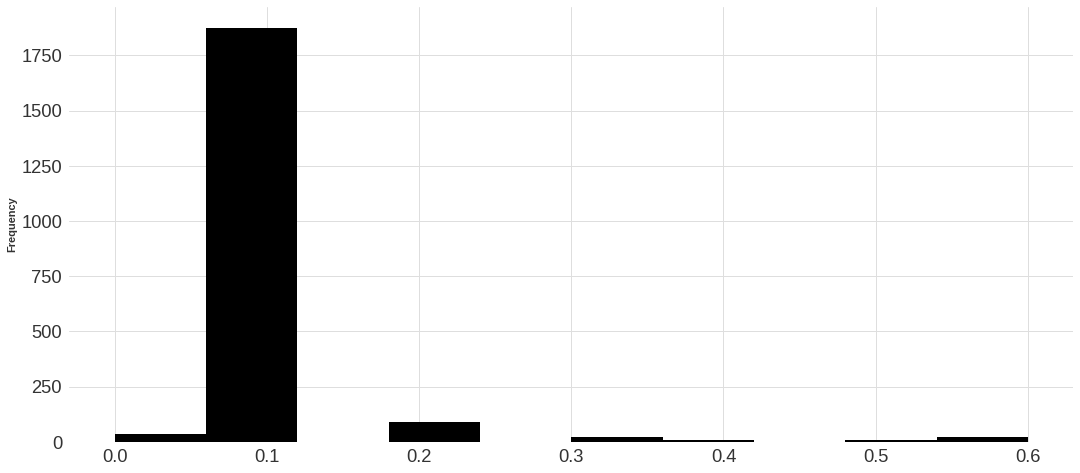

In [50]:
result_df['disount'].plot.hist()

In [51]:
alt.Chart(all_items_eval.reset_index()).mark_bar().encode(
    x=alt.X('model:N',scale=alt.Scale(zero=False)),
    y=alt.Y('profit_increase_%:Q',scale=alt.Scale(zero=False),axis=alt.Axis(format='%')),
    color=alt.Color('model:N')
).properties(width=250, height=250)#.interactive()

alt.Chart(...)

In [52]:
eval_df[['rmse','rmse_normalized']] = eval_df[['rmse','rmse_normalized']].astype('float16')#.groupby('model')#.sum()
all_items_eval[['rmse','rmse_normalized']] = eval_df.groupby('model').mean()[['rmse','rmse_normalized']]

In [53]:
all_items_eval

value  sell_price  daily_revenue   disount  \
model                                                                     
Fact                 211958.000000  395.389946  285054.632888  0.121429   
LGBM_cov             214662.577521  395.389946  288691.921183  0.102381   
LGBM_no_cov          213346.044982  395.389946  286921.364282  0.104762   
Naive weekly         214032.000000  395.389946  287843.880327  0.097619   
RegressionModelCov   219258.005609  395.389946  294872.145881  0.133333   
RegressionModelLags  218194.213157  395.389946  293441.489964  0.111905   
Theta                214441.154577  395.389946  288394.137490  0.114286   

                     sell_price_w_disount  value_increase  value_w_disount  \
model                                                                        
Fact                           347.378309           107.1    289986.800000   
LGBM_cov                       354.909546            90.3    280090.349907   
LGBM_no_cov                    353.968142            92.4    281430.437143   
Naive weekly                   356.792356            86.1    277095.600000   
RegressionModelCov             342.671286           117.6    303897.272209   
RegressionModelLags            351.143928            98.7    290918.250691   
Theta                          350.202523           100.8    287429.693364   

                     daily_revenue_w_disount   daily_profit  \
model                                                         
Fact                           337619.924026  171032.779733   
LGBM_cov                       337847.661733  173215.152710   
LGBM_no_cov                    337161.415508  172152.818569   
Naive weekly                   335903.985457  172706.328196   
RegressionModelCov             345980.922002  176923.287528   
RegressionModelLags            344732.886975  176064.893979   
Theta                          337710.803105  173036.482494   

                     daily_profit_w_disount  value_fact  daily_profit_fact  \
model                                                                        
Fact                          181622.828721    211958.0      171032.779733   
LGBM_cov                      187174.317263    211958.0      171032.779733   
LGBM_no_cov                   185767.177134    211958.0      171032.779733   
Naive weekly                  186841.653234    211958.0      171032.779733   
RegressionModelCov            182500.750713    211958.0      171032.779733   
RegressionModelLags           188234.721959    211958.0      171032.779733   
Theta                         183089.291818    211958.0      171032.779733   

                     value_w_disount_fact  daily_profit_w_disount_fact  \
model                                                                    
Fact                             289986.8                181622.828721   
LGBM_cov                         276604.4                184850.071389   
LGBM_no_cov                      279882.2                184507.857357   
Naive weekly                     274172.6                184977.806549   
RegressionModelCov               294222.8                176994.722166   
RegressionModelLags              282558.5                182723.129006   
Theta                            283686.2                181402.405551   

                     final_profit_w_disount_fact  final_profit_fact  \
model                                                                 
Fact                               171024.928721      156533.439733   
LGBM_cov                           174252.171389      157202.559733   
LGBM_no_cov                        173909.957357      157038.669733   
Naive weekly                       174379.906549      157324.149733   
RegressionModelCov                 166396.822166      156321.639733   
RegressionModelLags                172125.229006      156904.854733   
Theta                              170804.505551      156848.469733   

                     profit_increase_%     rmse  rmse_normalized  
model

In [54]:
chart = alt.Chart(all_items_eval.fillna(0).reset_index()).mark_circle().encode(
    x=alt.X('rmse:Q'),
    y=alt.Y('profit_increase_%:Q',axis=alt.Axis(format='%')),
    color=alt.Color('model:N'),
).properties(width=450, height=450)#.interactive()

fact_line = alt.Chart(pd.DataFrame({'y': [all_items_eval.loc['Fact','profit_increase_%']]})).mark_rule(strokeDash=[10, 10]).encode(y='y')

chart + fact_line

alt.LayerChart(...)

In [55]:
alt.Chart(all_items_eval.fillna(0).reset_index()).mark_circle().encode(
    x=alt.X('disount:Q',axis=alt.Axis(format='%')),
    y=alt.Y('profit_increase_%:Q',axis=alt.Axis(format='%')),
    color=alt.Color('model:N'),
).properties(width=450, height=450)#.interactive()

alt.Chart(...)

In [56]:
all_items_eval

value  sell_price  daily_revenue   disount  \
model                                                                     
Fact                 211958.000000  395.389946  285054.632888  0.121429   
LGBM_cov             214662.577521  395.389946  288691.921183  0.102381   
LGBM_no_cov          213346.044982  395.389946  286921.364282  0.104762   
Naive weekly         214032.000000  395.389946  287843.880327  0.097619   
RegressionModelCov   219258.005609  395.389946  294872.145881  0.133333   
RegressionModelLags  218194.213157  395.389946  293441.489964  0.111905   
Theta                214441.154577  395.389946  288394.137490  0.114286   

                     sell_price_w_disount  value_increase  value_w_disount  \
model                                                                        
Fact                           347.378309           107.1    289986.800000   
LGBM_cov                       354.909546            90.3    280090.349907   
LGBM_no_cov                    353.968142            92.4    281430.437143   
Naive weekly                   356.792356            86.1    277095.600000   
RegressionModelCov             342.671286           117.6    303897.272209   
RegressionModelLags            351.143928            98.7    290918.250691   
Theta                          350.202523           100.8    287429.693364   

                     daily_revenue_w_disount   daily_profit  \
model                                                         
Fact                           337619.924026  171032.779733   
LGBM_cov                       337847.661733  173215.152710   
LGBM_no_cov                    337161.415508  172152.818569   
Naive weekly                   335903.985457  172706.328196   
RegressionModelCov             345980.922002  176923.287528   
RegressionModelLags            344732.886975  176064.893979   
Theta                          337710.803105  173036.482494   

                     daily_profit_w_disount  value_fact  daily_profit_fact  \
model                                                                        
Fact                          181622.828721    211958.0      171032.779733   
LGBM_cov                      187174.317263    211958.0      171032.779733   
LGBM_no_cov                   185767.177134    211958.0      171032.779733   
Naive weekly                  186841.653234    211958.0      171032.779733   
RegressionModelCov            182500.750713    211958.0      171032.779733   
RegressionModelLags           188234.721959    211958.0      171032.779733   
Theta                         183089.291818    211958.0      171032.779733   

                     value_w_disount_fact  daily_profit_w_disount_fact  \
model                                                                    
Fact                             289986.8                181622.828721   
LGBM_cov                         276604.4                184850.071389   
LGBM_no_cov                      279882.2                184507.857357   
Naive weekly                     274172.6                184977.806549   
RegressionModelCov               294222.8                176994.722166   
RegressionModelLags              282558.5                182723.129006   
Theta                            283686.2                181402.405551   

                     final_profit_w_disount_fact  final_profit_fact  \
model                                                                 
Fact                               171024.928721      156533.439733   
LGBM_cov                           174252.171389      157202.559733   
LGBM_no_cov                        173909.957357      157038.669733   
Naive weekly                       174379.906549      157324.149733   
RegressionModelCov                 166396.822166      156321.639733   
RegressionModelLags                172125.229006      156904.854733   
Theta                              170804.505551      156848.469733   

                     profit_increase_%     rmse  rmse_normalized  
model